In [83]:
import keras
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Optimizer
from keras import callbacks

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import Image

np.random.seed(17)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
keras.__version__

'2.8.0'

In [3]:
! ls drive/MyDrive/Tutorial/week\ 11/

amazon_reviews.csv  glove.6B.300d.txt


In [4]:
DATA_FILE_PATH = 'drive/MyDrive/Tutorial/week 11/amazon_reviews.csv' 
# If you don't have glove 300d, download it from https://www.kaggle.com/thanakomsn/glove6b300dtxt
EMB_DIR = 'drive/MyDrive/Tutorial/week 11/glove.6B.300d.txt'

MAX_TEXT_VOCAB_SIZE = 30000
MAX_SUMMARY_VOCAB_SIZE = 10000 
MAX_TEXT_LEN = 100 # HOW WE GOT THIS? I WILL SHOW YOU LATER
MAX_SUMMARY_LEN = 5 # HOW WE GOT THIS? I WILL SHOW YOU LATER

LSTM_DIM = 300
EMBEDDING_DIM = 300

BATCH_SIZE = 128
N_EPOCHS = 1

In [6]:
df = pd.read_csv(DATA_FILE_PATH)
# Converting all columns to string
df['Summary'] = df['Summary'].apply(lambda x: str(x))
df['Text'] = df['Text'].apply(lambda x: str(x))

print('Number of rows = ', df.shape[0])
df

Number of rows =  100000


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...
...,...,...
99995,yummy!,I just love it and will buy another box when I...
99996,Tastes like More!,My late father in law used to have a rating sy...
99997,Great ramen,This is my favorite brand of Korean ramen. It ...
99998,Spicy!!,"I do like these noodles although, to say they ..."


In [15]:
sent_len = lambda x:len(x)
df['Summary_length'] = df.Summary.apply(sent_len)
df[df['Summary_length']<5]['Summary']

46       good
76       Good
99        Bad
310       WOW
316      Hot!
         ... 
99697    WOW!
99750    Whoa
99797     yuk
99880    Yum!
99929     WOW
Name: Summary, Length: 1509, dtype: object

In [16]:
# Summaries having lesser than 5 characters can be discarded - noisy data
indices = df[df['Summary_length']<5].index
df.drop(indices, inplace=True)

# Can drop the Summary_length columns - to save memory
df.drop('Summary_length', inplace=True, axis=1)

df.reset_index(inplace=True, drop=True)
df.shape

(98491, 2)

In [18]:
# THIS IS HOW WE GOT MAX_TEXT_LEN = 100
# THIS IS HOW WE GOT MAX_SUMMARY_LEN = 5

word_count = lambda x:len(x.split()) # Word count for each question
df['s_wc'] = df.Summary.apply(word_count)
df['t_wc'] = df.Text.apply(word_count)

p = 75.0

print(' Summary :{} % of the summaries have a length less than or equal to {}'.format(p, np.percentile(df['s_wc'], p)))
print(' Text :{} % of the texts have a length less than or equal to {}'.format(p, np.percentile(df['t_wc'], p)))

 Summary :75.0 % of the summaries have a length less than or equal to 5.0
 Text :75.0 % of the texts have a length less than or equal to 100.0


In [22]:
text_list = [' '.join(word_tokenize(x)[:MAX_TEXT_LEN]) for x in df['Text']]
summary_list = [' '.join(word_tokenize(x)[:MAX_SUMMARY_LEN]) for x in df['Summary']]

## Separate embedding matrices - one for encoder side (Texts), one for decoder side (Summary)


* We could use a shared embedding matrix if the source and target have similar vocabularies (same size and same domain). Eg. for dialogue generation

* If the vocabularies are different, e.g., machine translation, we definitely need to use different embedding matrices

* In this case, the summaries (decoder side) will have a smaller vocabulary than the texts (source side). It is not efficient to use a shared vocabulary/shared embedding matrix. For example, on the decoder side if we have 30,000 words vs. 5,000 words -> it is more difficult for the decoder (the softmax) to select 1 word from 30,000 choices vs. 1 from 5,000.

# Preparing the word-to-index mapping

Special tokens

* PAD [Padding]
* SOS [Start of sentence] (only required for the decoder input, for the 1st timestep to inform the decoder that it can now start decoding)
* EOS [End of sentence]
* UNK [Unknown]

In [29]:
filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

text_tokenizer = Tokenizer(filters=filter_list)
text_tokenizer.fit_on_texts(text_list)
print("Number of words in TEXT vocabulary:", len(text_tokenizer.word_index))

summary_tokenizer = Tokenizer(filters=filter_list)  
summary_tokenizer.fit_on_texts(summary_list)
print("Number of words in SUMMARY vocabulary:", len(summary_tokenizer.word_index))

Number of words in TEXT vocabulary: 45418
Number of words in SUMMARY vocabulary: 13409


In [43]:
text_word_index = {}
text_word_index['PAD'] = 0
text_word_index['UNK'] = 1
text_word_index['EOS'] = 2

for i, word in enumerate(dict(text_tokenizer.word_index).keys()):
  if not word == "PAD" and not word == "UNK" and not word == "EOS":
      text_word_index[word] = i+3 # Move existing indices up by 3 places
    
text_tokenizer.word_index = text_word_index
X = text_tokenizer.texts_to_sequences(text_list)

# Replace OOV words with UNK token
# Append EOS to the end of all sentences
for i, seq in enumerate(X):
    if any(t>=MAX_TEXT_VOCAB_SIZE for t in seq):
        seq = [t if t<MAX_TEXT_VOCAB_SIZE else text_word_index['UNK'] for t in seq ]
    seq.append(text_word_index['EOS'])
    X[i] = seq    
    
# Padding and truncating sequences
X = pad_sequences(X, padding='post', truncating='post', maxlen=MAX_TEXT_LEN, value=text_word_index['PAD'])

# Finalize the dictionaries
text_word_index = {k: v for k, v in text_word_index.items() if v < MAX_TEXT_VOCAB_SIZE} 
text_idx_to_word = dict((i, word) for word, i in text_word_index.items())

In [46]:
X

array([[   7,   21,  117, ...,    0,    0,    0],
       [  45,  316, 2118, ...,    0,    0,    0],
       [  14,   13,    9, ...,    0,    0,    0],
       ...,
       [  14,   13,   17, ...,    0,    0,    0],
       [   7,   49,   33, ...,    0,    0,    0],
       [   7,   52,   14, ...,    0,    0,    0]], dtype=int32)

In [47]:
summary_word_index = {}
summary_word_index['PAD'] = 0
summary_word_index['UNK'] = 1
summary_word_index['EOS'] = 2
summary_word_index['SOS'] = 3

for i, word in enumerate(dict(summary_tokenizer.word_index).keys()):
  if not word == "PAD" and not word == "UNK" and not word == "EOS" and not word == "SOS":
    summary_word_index[word] = i+4 # Move existing indices up by 4 places
    
summary_tokenizer.word_index = summary_word_index
Y = summary_tokenizer.texts_to_sequences(summary_list)

# Replace OOV words with UNK token
# Append EOS to the end of all sentences
for i, seq in enumerate(Y):
    if any(t>=MAX_SUMMARY_VOCAB_SIZE for t in seq):
        seq = [t if t<MAX_SUMMARY_VOCAB_SIZE else summary_word_index['UNK'] for t in seq ]
    seq.append(summary_word_index['EOS'])
    Y[i] = seq    
    
# Padding and truncating sequences
Y = pad_sequences(Y, padding='post', truncating='post', maxlen=MAX_SUMMARY_LEN, value=summary_word_index['PAD'])

# Finalize the dictionaries
summary_word_index = {k: v for k, v in summary_word_index.items() if v < MAX_SUMMARY_VOCAB_SIZE} 
summary_idx_to_word = dict((i, word) for word, i in summary_word_index.items()) 

In [48]:
Y

array([[   5,   68,   28,   35,    2],
       [   9,   44,  538,    2,    0],
       [ 474,  452,   14,    2,    0],
       ...,
       [   4,  719,    2,    0,    0],
       [ 145,    2,    0,    0,    0],
       [  18,  145,  552, 7430,   12]], dtype=int32)

## Train-Validation-Test Splits

In [49]:
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=0.05)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5)

# Embedding Matrix


In [62]:
# Load GloVe word embeddings 
# Download Link: https://nlp.stanford.edu/projects/glove/
print("[INFO]: Reading Word Embeddings ...")
# Data path
embeddings = {}
f = open(EMB_DIR)
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings[word] = vector
f.close()

[INFO]: Reading Word Embeddings ...


In [57]:
encoder_embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(text_word_index) + 3, EMBEDDING_DIM)) 

for word, i in text_word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        encoder_embeddings_matrix[i] = embeddings_vector

In [58]:
print(encoder_embeddings_matrix.shape)

(30000, 300)


In [63]:
decoder_embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(summary_word_index), EMBEDDING_DIM)) 

for word, i in summary_word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        decoder_embeddings_matrix[i] = embeddings_vector

In [64]:
print(decoder_embeddings_matrix.shape)

(10000, 300)


# Model during training

Input: [where, do, you, live, ?, EOS]

Output: [I, reside, in, waterloo, EOS]

When the model predicts wrongly, we need to correct it so that errors are not accumulated. TEACHER FORCING

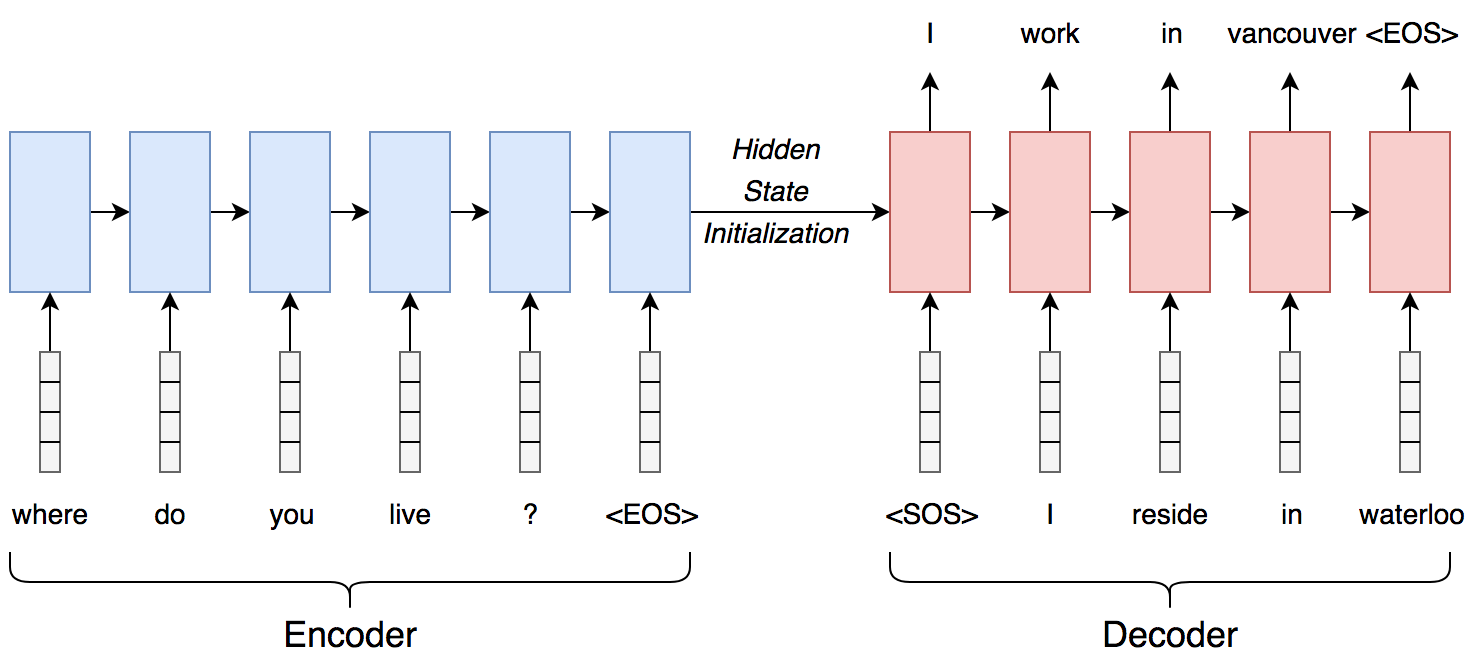

# Keras Model Building
Adapted from Keras blog post: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [65]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras import backend as K



When the datasets are huge, it is a good idea to make use of the keras fit_generator.
Basically, we need to generator function that feeds inputs and corresponding outputs in a batch_wise fashion.

In our case, we have

* encoder inputs
* decoder inputs (which is the ground truth delayed by 1 timestep)
* decoder outputs

For decoder outputs for each token, we need to predict a softmax of the vocabulary |V|. If we have m tokens and a training data size of n, we need to store a huge tensor of size n x m x |V|. In our case, 100000 x 5 x 10000.

This may not fit in memory. Even if it fits, it is not a good practice to keep such large variables, hence use the fit generator


In [70]:
def prepare_data(X, Y, batch_start, batch_end):
    
    # Encoder input
    X_enc = X[batch_start:batch_end] 

    # Decoder input
    # Concatenate a column of 3s (i.e., SOS token) to the Y and remove the last element
    X_dec = np.c_[3 * np.ones([len(Y[batch_start:batch_end])]), Y[batch_start:batch_end, :-1]]

    # Decoder output - one hot encoded for softmax layer - 1 in |V|
    Y_dec = np.array([to_categorical(y, num_classes=len(summary_word_index)) for y in Y[batch_start:batch_end]])

    return [X_enc, X_dec], Y_dec

In [71]:
def batch_generator(X, Y, BATCH_SIZE):

    # this line is just to make the generator infinite, keras needs that    
    while True:
        
        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < len(X):
            
            [X_enc, X_dec], Y_dec = prepare_data(X, Y, batch_start, batch_end)
            
            yield ([X_enc, X_dec], Y_dec) 

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

### Sequence-to-sequence model for training:

In [72]:
K.set_learning_phase(1) # 1 for training, 0 for inference time

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [73]:
# Encoder Setup
enc_input = Input(shape=(MAX_TEXT_LEN, ), name='encoder_input')
enc_emb_look_up = Embedding(input_dim=MAX_TEXT_VOCAB_SIZE,
                             output_dim=EMBEDDING_DIM,
                             weights = [encoder_embeddings_matrix], 
                             trainable=False, 
                             mask_zero=True,
                             name='encoder_embedding_lookup')

enc_emb_text = enc_emb_look_up(enc_input)

encoder_lstm = LSTM(LSTM_DIM, return_state=True, name='encoder_lstm', dropout=0.2) # To return the final state of the encoder
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb_text)
encoder_states = [state_h, state_c] # Discard encoder_outputs (at each time step) and only keep the final states.

In [74]:
# Decoder Setup
dec_input = Input(shape=(None, ), name='decoder_input') # Specify None instead of MAX_SUMMARY_LEN
# So that we can use the decoder with one-token prediction at a time
# By specifying MAX_SUMMARY_LEN, we limit this capability of the decoder
# That is, if MAX_SUMMARY_LEN is specified, we always have to provide MAX_SUMMARY_LEN tokens as input to the decoder
# By not specifying, we can dynamically adjust it, i.e., MAX_SUMMARY_LEN during training and 1 during inference

dec_emb_look_up = Embedding(input_dim=MAX_SUMMARY_VOCAB_SIZE,
                             output_dim=EMBEDDING_DIM,
                             weights = [decoder_embeddings_matrix], 
                             trainable=False, 
                             mask_zero=True,
                             name='decoder_embedding_lookup')

dec_emb_text = dec_emb_look_up(dec_input)

# We set up our decoder to return full output sequences,
# and to return internal LSTM states (h, c) as well. We don't use the 
# return states in the training model, but we will use them during inference.
decoder_lstm = LSTM(LSTM_DIM, return_sequences=True, return_state=True, name='decoder_lstm', dropout=0.2)
# Dropout needs to be set back to 0.0 for the inference time

# Hidden state initialization using `encoder_states` as initial state.
decoder_outputs, _, _ = decoder_lstm(dec_emb_text,
                                     initial_state=encoder_states)

decoder_dense = Dense(MAX_SUMMARY_VOCAB_SIZE, activation='softmax', name='output_layer')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([enc_input, dec_input], decoder_outputs)

In [75]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 100)]        0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 encoder_embedding_lookup (Embe  (None, 100, 300)    9000000     ['encoder_input[0][0]']          
 dding)                                                                                           
                                                                                                  
 decoder_embedding_lookup (Embe  (None, None, 300)   3000000     ['decoder_input[0][0]']      

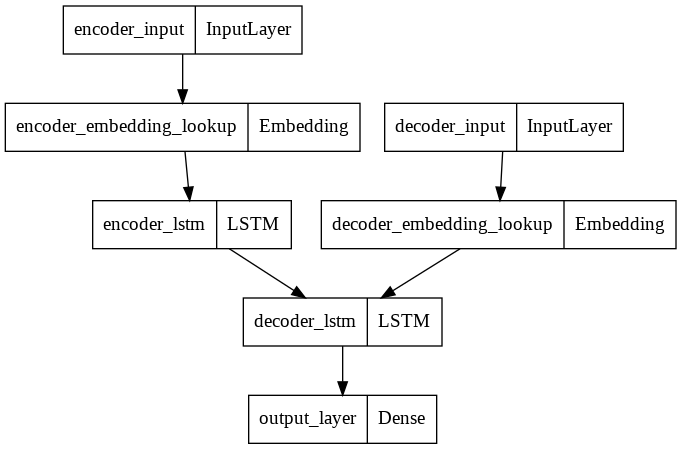

In [81]:
plot_model(model, to_file='full_model.png', show_layer_names=True)
Image('full_model.png')

# Model Training


In [84]:
# Set optimizer and loss function 
optimizer = keras.optimizers.Adam(lr=0.001) # Try a different learning rate

loss = 'categorical_crossentropy'

filepath="saved_models/seq2seq_textsummarization_{epoch:02d}_{val_loss:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_loss', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Note: It is possible to write your own callback functions by instructing what needs to be done at the end of each epoch.

Homework - write a callback function to calculate BLEU scores on validation set and print generated samples at the end of each epoch
Check out https://keunwoochoi.wordpress.com/2016/07/16/keras-callbacks/


In [85]:
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
VAL_STEPS = len(X_val)//BATCH_SIZE

In [103]:
for epoch in range(3):
  model.fit_generator(batch_generator(X_train, Y_train, BATCH_SIZE), 
                      steps_per_epoch = STEPS_PER_EPOCH, 
                      epochs = N_EPOCHS,
                      validation_data = batch_generator(X_val, Y_val, BATCH_SIZE), 
                      validation_steps = VAL_STEPS, 
                      callbacks = callbacks_list,
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


730/730 [==============================] - 68s 93ms/step - loss: 3.3225 - val_loss: 3.3633


Note: It is best to write the above code onto a .py file and execute it directly on the command line.

We may need to train the model for over 100 epcohs to get good sentence generations.

In this case, the model was trained for 100 epochs, about 300 seconds (~5mins) per epoch on a single GPU.


# Load Saved Model


In [87]:
from keras import models

In [91]:
model_file_path = '/content/saved_models/seq2seq_textsummarization_01_4.0358.h5'
model = models.load_model(model_file_path)

In [106]:
TEST_STEPS = len(X_test)//BATCH_SIZE

# Obtain the last layer output, i.e., the softmax probabilities
preds = model.predict_generator(batch_generator(X_test, Y_test, BATCH_SIZE), steps = TEST_STEPS) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


In [107]:
preds.shape

(2432, 5, 10000)

In [108]:
# Greedy Decoding
outputs = [np.argmax(p, axis = -1) for p in preds]
outputs[:10]

[array([ 4, 44,  2,  2,  2]),
 array([  9, 163,   2,   2,   2]),
 array([   4, 2027,    2,   72,   46]),
 array([4, 2, 2, 0, 1]),
 array([12,  7,  7,  2, 28]),
 array([  9,  10,  63, 149,  49]),
 array([  4,   4, 127,   2,   2]),
 array([ 4, 44,  5, 44, 16]),
 array([ 10,  10, 287, 931,   2]),
 array([  9,   8, 358, 183,   2])]

In [109]:
def show_summary_sentence(gen_ids):
    pad = summary_word_index['PAD']
    eos = summary_word_index['EOS']
    print(' '.join([summary_idx_to_word[w] for w in gen_ids if w not in [pad, eos]]))

In [110]:
def show_input_text(inp_ids):
    pad = text_word_index['PAD']
    eos = text_word_index['EOS']
    print(' '.join([text_idx_to_word[w] for w in inp_ids if w not in [pad, eos]]))

In [111]:
for i in range(26, 30):
    show_input_text(X_test[i])
    print()
    print('Summary - ', end='')
    show_summary_sentence(outputs[i])
    print('\n----------------------------')

we buy our cats a high quality food for everyday eating and they do get cat treats which can add up when you have 4 cats i saw these on special and ordered for a great price i took the extra bags and sealed them up in food saver bags and put them in the freezer and kept one out to put in the treat jar br they love it its got all the UNK dazzle the healthy food does n t so when i give them each a little of this they think they

Summary - great for dogs

----------------------------
this product describes itself as 100 natural arabic this is pretty much what it is coffee and a some sugar i assume that most people will be buying this for a hit of caffeine so i ll compare it to some popular alternatives br br healthy let s face it most of the other energy drinks and caffeinated sodas on the market are chemicals and water some of them throw in a couple of vitamins to give the impression that they

Summary - good me price

----------------------------
as always a pleasure to work with produc

# Inference

## Is this the right way to test?
No! There is no decoder input/output (Y_test) available at inference or test time!


### Sequence-to-sequence model for inference:

At timestep t, we predict a target token, then use the embedding of the predicted token as input to timestep (t+1)

Look at the picture

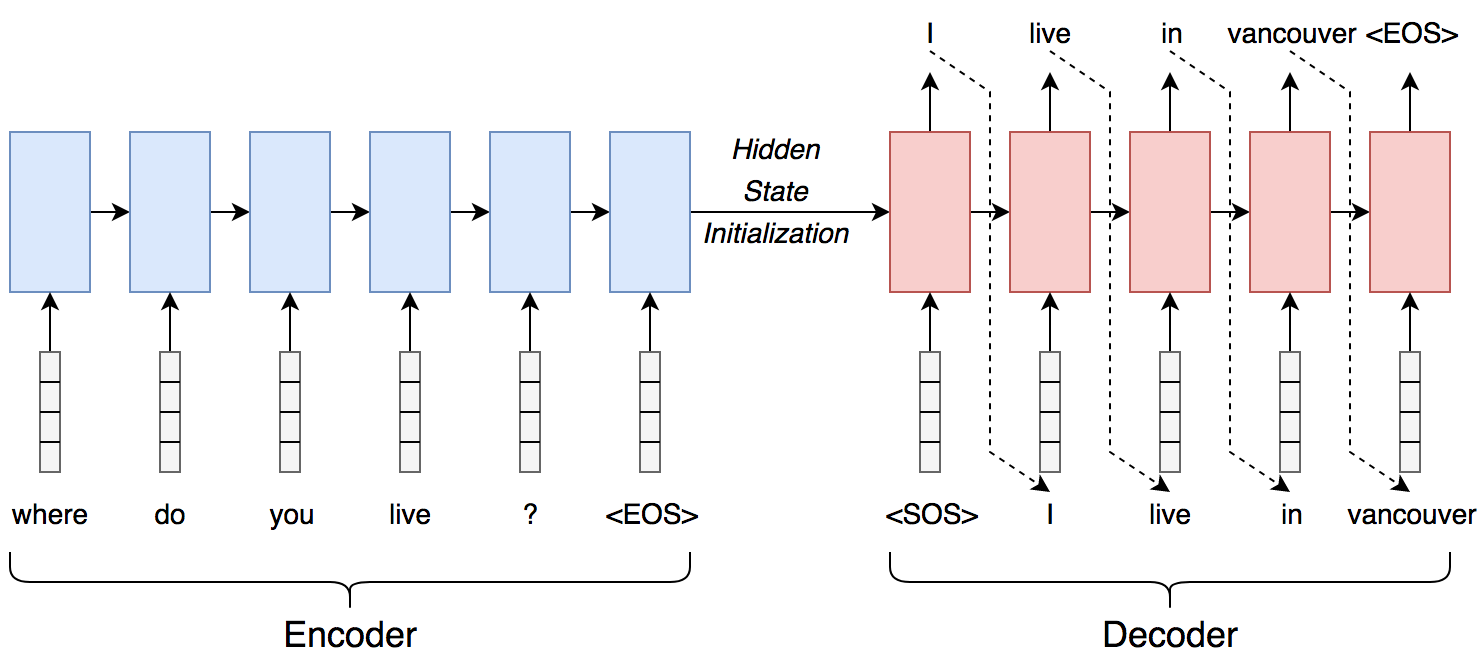


# Encoder

In [104]:
encoder_model = Model(enc_input, encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 encoder_embedding_lookup (E  (None, 100, 300)         9000000   
 mbedding)                                                       
                                                                 
 encoder_lstm (LSTM)         [(None, 300),             721200    
                              (None, 300),                       
                              (None, 300)]                       
                                                                 
Total params: 9,721,200
Trainable params: 721,200
Non-trainable params: 9,000,000
_________________________________________________________________


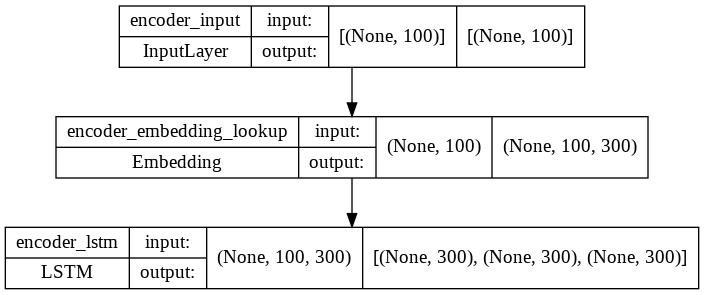

In [105]:
plot_model(encoder_model, to_file='encoder_model.png', show_layer_names=True, show_shapes=True)
Image('encoder_model.png')

# Decoder
At inference time, we predict ONE TOKEN AT A TIME

* Input: previous cell/hidden states and the embedding of the token from the previous time step
* Output: current cell/hidden states and the output token's embedding

In [112]:
decoder_state_input_h = Input(shape=(LSTM_DIM,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(LSTM_DIM,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(inputs=dec_emb_text, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(inputs = [dec_input] + decoder_states_inputs,
                      outputs = [decoder_outputs] + decoder_states
                     )

In [113]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 decoder_embedding_lookup (Embe  (None, None, 300)   3000000     ['decoder_input[0][0]']          
 dding)                                                                                           
                                                                                                  
 decoder_state_input_h (InputLa  [(None, 300)]       0           []                               
 yer)                                                                                             
                                                                                            

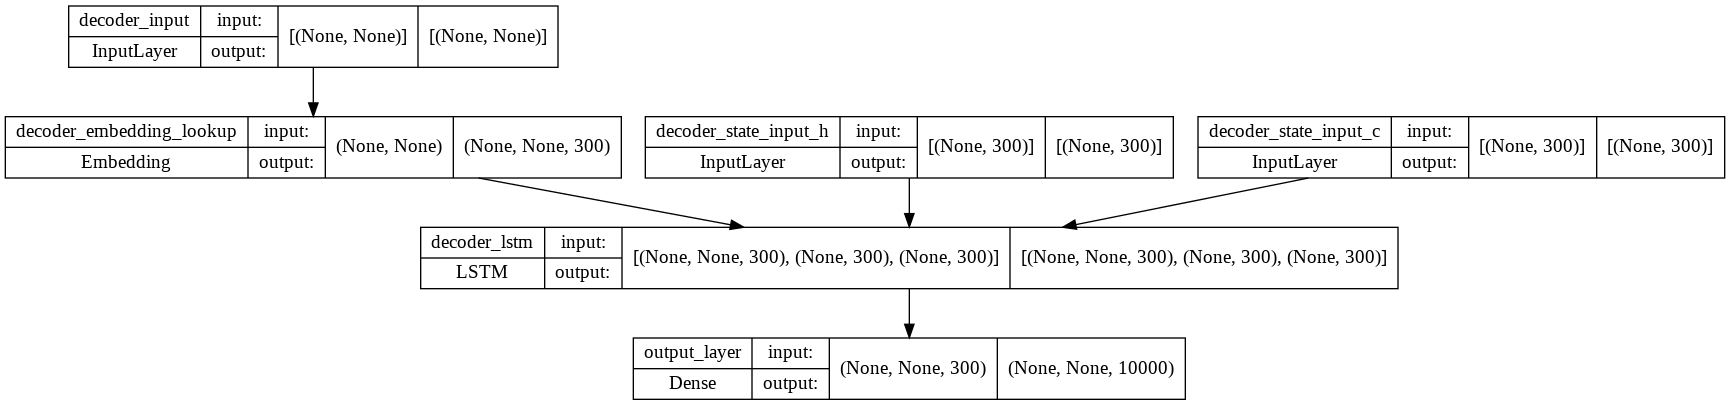

In [114]:
plot_model(decoder_model, to_file='decoder_model.png', show_layer_names=True, show_shapes=True)
Image('decoder_model.png')

## Weight Transfer

The above encoder and decoder models that we setup for inference have been initialized with random weights.

Take the weights of the trained model (that is loaded into memory) and assign the encoder and decoder models with these weights.

For weight transfer, the important thing to keep in mind is that we do not mis-align any weight matrices.

Use
`model.get_weights()`
and
`model.set_weights()`

In [122]:
model.weights

[<tf.Variable 'encoder_embedding_lookup/embeddings:0' shape=(30000, 300) dtype=float32, numpy=
 array([[ 0.01463626,  0.04556191,  0.01699129, ...,  0.03854867,
         -0.00460922, -0.03501487],
        [-0.0366037 ,  0.04242148, -0.01017895, ...,  0.03732036,
         -0.04898562, -0.01981451],
        [ 0.03199953,  0.01376403, -0.00860155, ...,  0.03666693,
         -0.00149499,  0.04094407],
        ...,
        [ 0.17555   , -0.046708  ,  0.34473   , ...,  0.37441   ,
          0.27424   , -0.55546   ],
        [ 0.087736  , -0.011145  ,  0.22451   , ...,  0.35637   ,
         -0.088682  , -0.28568   ],
        [-0.15761   , -0.40502   , -0.095593  , ...,  0.21501   ,
          0.42468   , -0.1357    ]], dtype=float32)>,
 <tf.Variable 'decoder_embedding_lookup/embeddings:0' shape=(10000, 300) dtype=float32, numpy=
 array([[-0.02979364, -0.02231477, -0.00263474, ...,  0.01081035,
          0.04173709,  0.00431845],
        [-0.04458035,  0.0256318 , -0.02063676, ..., -0.02106135,

In [117]:
model_weight_list = model.get_weights()

encoder_indices = [0, 2, 3, 4] # Index 1 is the decoder-side embedding matrix weights
encoder_weights = [model_weight_list[idx] for idx in encoder_indices]
encoder_model.set_weights(encoder_weights)

decoder_indices = list(set(range(len(model_weight_list))) - set(encoder_indices))
decoder_weights = [model_weight_list[idx] for idx in decoder_indices]
decoder_model.set_weights(decoder_weights)

In [123]:
# Specify that we are now at the inference stage, i.e., NOT learning
K.set_learning_phase(0)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [124]:
def decode_test_sequence(test_seq_input):
    
    # Retrieve the encoder output states, h and c
    states_value = encoder_model.predict(test_seq_input)

    # Initialize the decoding process
    time_step = 0
    stop_condition = False
    input_seq_decoder = [summary_word_index['SOS']] # Start with SOS token
    output_seq = [] 

    print('Timestep | Input ----> Output')

    while not stop_condition:

        output_probs, h, c = decoder_model.predict([np.array([input_seq_decoder]), 
                                                 states_value[0], 
                                                 states_value[1]] )

        predicted_token = np.argmax(output_probs, axis=-1)[0][time_step]
        output_seq.append(predicted_token)

        print(time_step + 1, '|', input_seq_decoder, '---->', output_seq)

        time_step += 1

        # Stop iteration either when EOS is reached or when we reach the last timestep
        # Timestep is from 0 to 4. Max allowed is 4
        if (predicted_token == summary_word_index['EOS'] or time_step > MAX_SUMMARY_LEN - 1): 
                stop_condition = True
        else:
            # Create the inputs for the next iteration
            input_seq_decoder.append(predicted_token)

            states_value[0] = h
            states_value[1] = c
                
    print('\n----------------------------')
    print('Text - ', end='')
    show_input_text(test_seq_input[0])
    print()
    print('Summary - ', end='')
    show_summary_sentence(output_seq)
    
    return output_seq

In [125]:
test_seq_inp = X_test[15:16]
test_output_gen = decode_test_sequence(test_seq_inp)

Timestep | Input ----> Output
1 | [3] ----> [12]
2 | [3, 12] ----> [12, 28]
3 | [3, 12, 28] ----> [12, 28, 42]
4 | [3, 12, 28, 42] ----> [12, 28, 42, 70]
5 | [3, 12, 28, 42, 70] ----> [12, 28, 42, 70, 2]

----------------------------
Text - my dog loves them i have cut them into smaller pieces and she will chew for quite a while to finish one off i still do n t know if it helps her digestion but she sure loves them

Summary - my dog loves them



Next Steps

* Monitor loss, BLEU scores and generated sentences.
* Beam Search Decoder

* Attention Mechanism: are very helful in seq2seq models
  * Links:
    * https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
    * https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html

* Visualize attention using the greyscale matrices

Code by HareeshBahuleyan